In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [ ]:
def parser(s):
    return datetime.strptime(s, '%m-%d-%Y')

In [ ]:
#read data
path = '/content/BTS_onsite_data.csv'
bts_data = pd.read_csv(path)

In [ ]:
bts_data.head()

,Date,Load_Power(kW)
0,12/1/2023 0:00,5.9
1,12/1/2023 1:00,5.7
2,12/1/2023 2:00,5.6
3,12/1/2023 3:00,5.6
4,12/1/2023 4:00,5.6


In [ ]:
# prompt: make the date column index and turn it to datetime data type

bts_data = bts_data.set_index('Date')
bts_data.index = pd.to_datetime(bts_data.index) # Use '/' as the separator in the format string


In [ ]:
#infer the frequency of the data
bts_data = bts_data.asfreq(pd.infer_freq(bts_data.index))

Text(0, 0.5, 'Power (kW)')

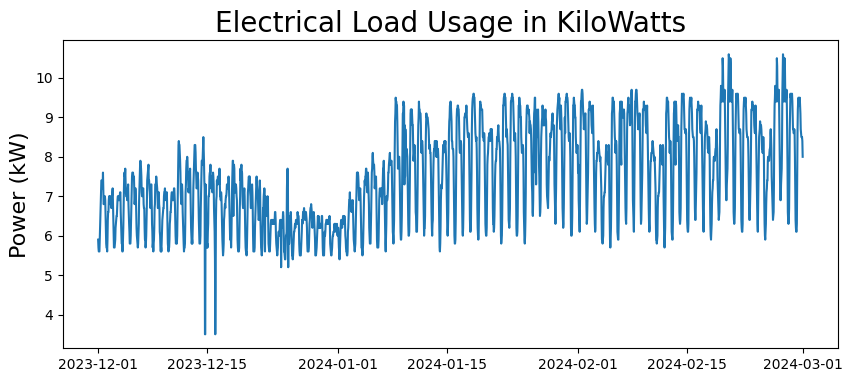

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(bts_data)
plt.title('Electrical Load Usage in KiloWatts', fontsize=20)
plt.ylabel('Power (kW)', fontsize=16)


<BarContainer object of 20 artists>

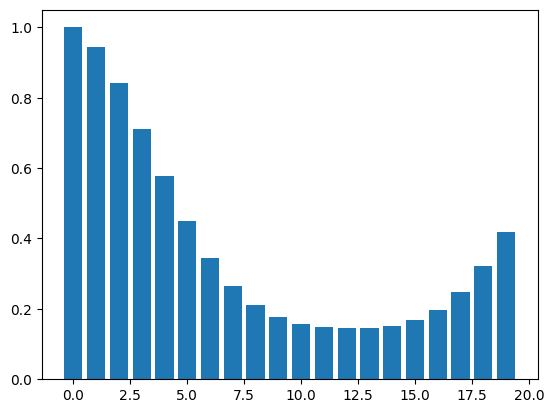

In [ ]:
acf_vals = acf(bts_data)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

In [ ]:
first_diff = bts_data.diff()[1:]

In [ ]:
first_diff.head()

,Load_Power(kW)
Date,
2023-12-01 01:00:00,-0.2
2023-12-01 02:00:00,-0.1
2023-12-01 03:00:00,0.0
2023-12-01 04:00:00,0.0
2023-12-01 05:00:00,0.3


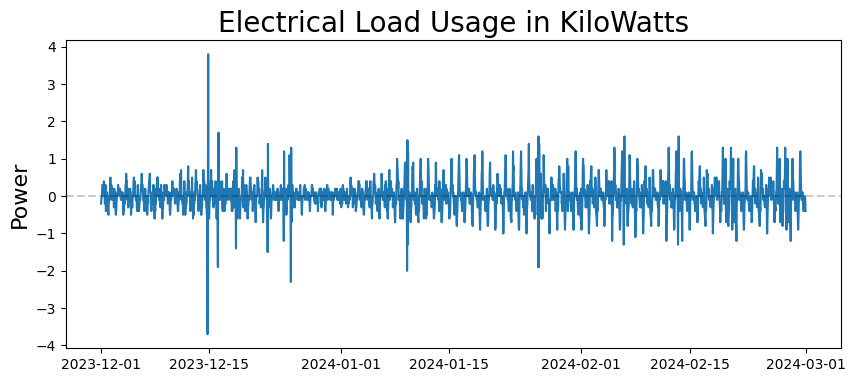

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Electrical Load Usage in KiloWatts', fontsize=20)
plt.ylabel('Power', fontsize=16)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

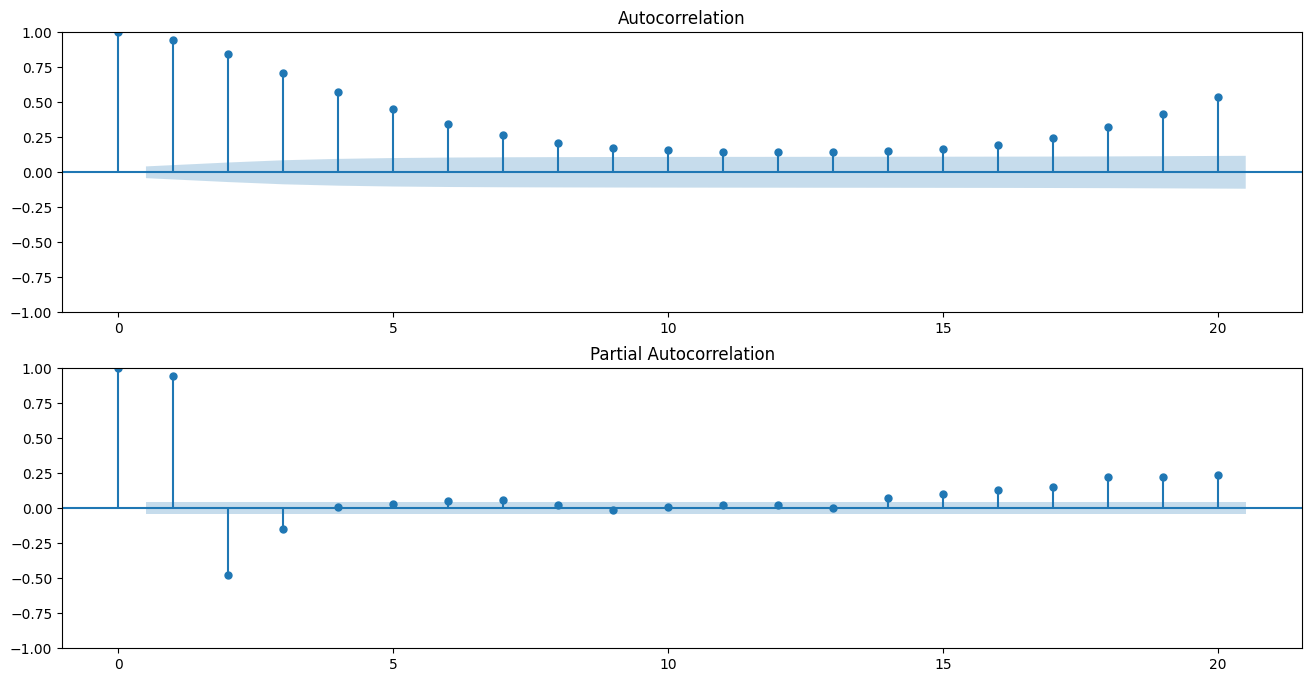

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(bts_data['Load_Power(kW)'], lags=20, ax=ax[0])
plot_pacf(bts_data['Load_Power(kW)'], lags=20, ax=ax[1])

plt.show()

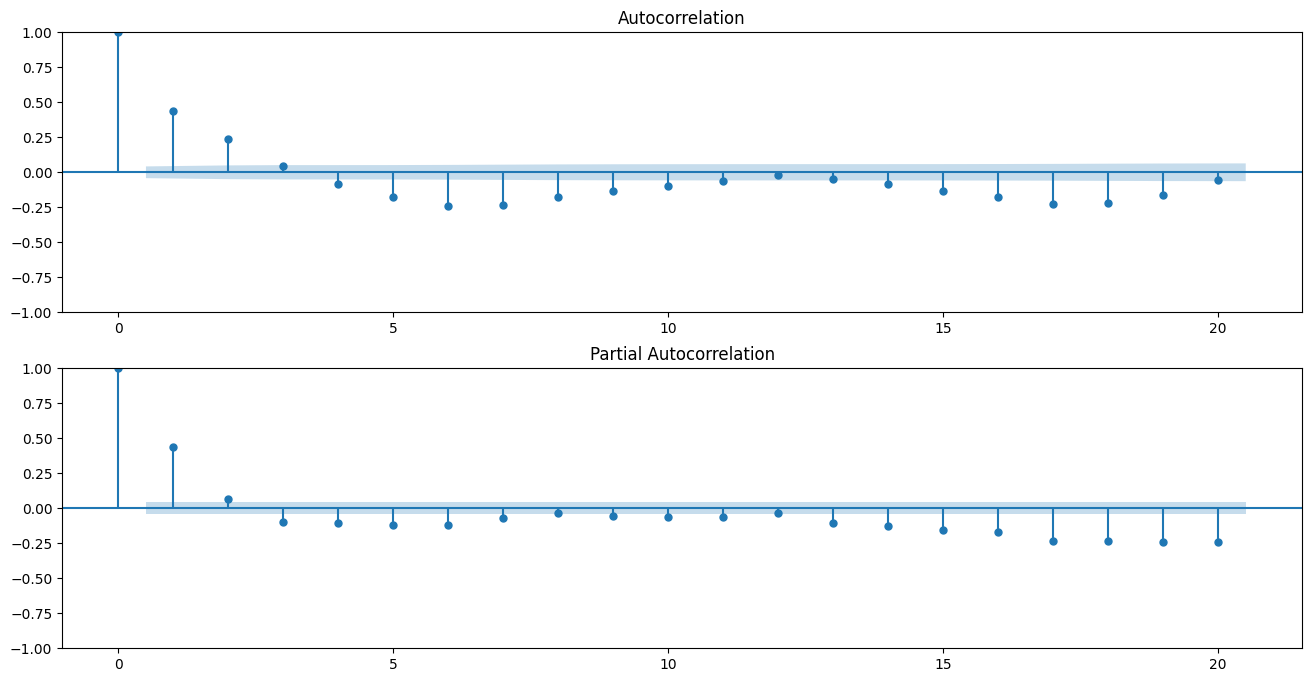

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(first_diff['Load_Power(kW)'], lags=20, ax=ax[0])
plot_pacf(first_diff['Load_Power(kW)'], lags=20, ax=ax[1])

plt.show()

<BarContainer object of 20 artists>

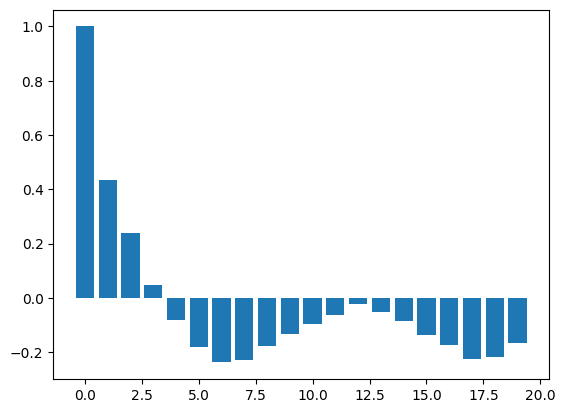

In [ ]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 15 artists>

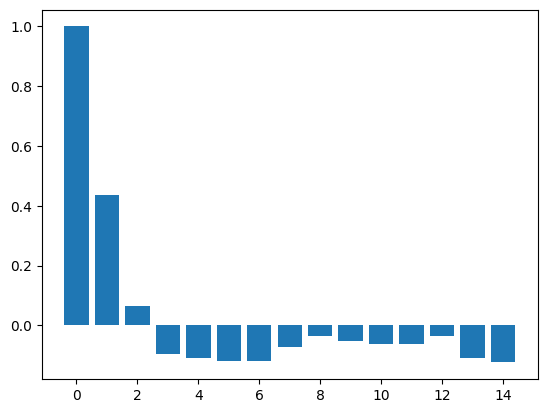

In [ ]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [ ]:
# prompt: split my data into test(20%) and train(80%)

train_end = int(len(bts_data) * 0.8)
train_data = bts_data[:train_end]
test_data = bts_data[train_end:]


In [ ]:
my_order = (1,0,0)
my_seasonal_order = (0, 1, 2, 24)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [ ]:
#!pip install pmdarima

In [ ]:
# from pmdarima.arima import auto_arima
# #Autoarima gives us bet model suited for the data
# # p - number of autoregressive terms (AR)
# # q - Number of moving avergae terms (MA)
# # d - number of non-seasonal differences
# #p, d, q represent non-seasonal components
# #P, D, Q represent seasonal components
# arima_model = auto_arima(bts_data['Load_Power(kW)'], start_p = 0, d=0, start_q = 0,
#                           max_p = 2, max_q = 2, max_d=0, m = 24,
#                           start_P = 1, D=1, start_Q=1, max_P=2, max_D=1, max_Q=2,
#                           seasonal = True,
#                           trace = True,
#                           error_action ='ignore',
#                           suppress_warnings = True,
#                           stepwise = True, n_fits=50)

In [ ]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 37.204110860824585


In [ ]:
#summary of the model
print(model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                          Load_Power(kW)   No. Observations:                 1747
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 24)   Log Likelihood                -318.442
Date:                                 Sun, 01 Sep 2024   AIC                            644.885
Time:                                         20:15:53   BIC                            666.692
Sample:                                     12-01-2023   HQIC                           652.953
                                          - 02-11-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8550      0.007    131.258      0.000       0.842       0

In [ ]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

In [ ]:
# Assuming 'predictions' and 'test_data' are defined

results_df = pd.DataFrame({
    'Actual': test_data['Load_Power(kW)'],
    'Predicted': predictions
})

print(results_df)

                     Actual  Predicted
Date                                  
2024-02-11 19:00:00     7.9   8.078855
2024-02-11 20:00:00     7.8   8.303360
2024-02-11 21:00:00     7.9   8.320063
2024-02-11 22:00:00     8.3   8.111913
2024-02-11 23:00:00     8.2   7.683516
...                     ...        ...
2024-02-29 19:00:00     8.5   8.413048
2024-02-29 20:00:00     8.5   8.609245
2024-02-29 21:00:00     8.5   8.613205
2024-02-29 22:00:00     8.4   8.379987
2024-02-29 23:00:00     8.0   7.908887

[437 rows x 2 columns]


In [ ]:
# prompt: write code to export result_df as excel file

results_df.to_excel('results.xlsx')


Mean Squared Error (MSE): 0.40031799281597497
Root Mean Squared Error (RMSE): 0.6327068774843332
Mean Absolute Error (MAE): 0.49074746726464885
R-squared (R2): 0.7115873179166032


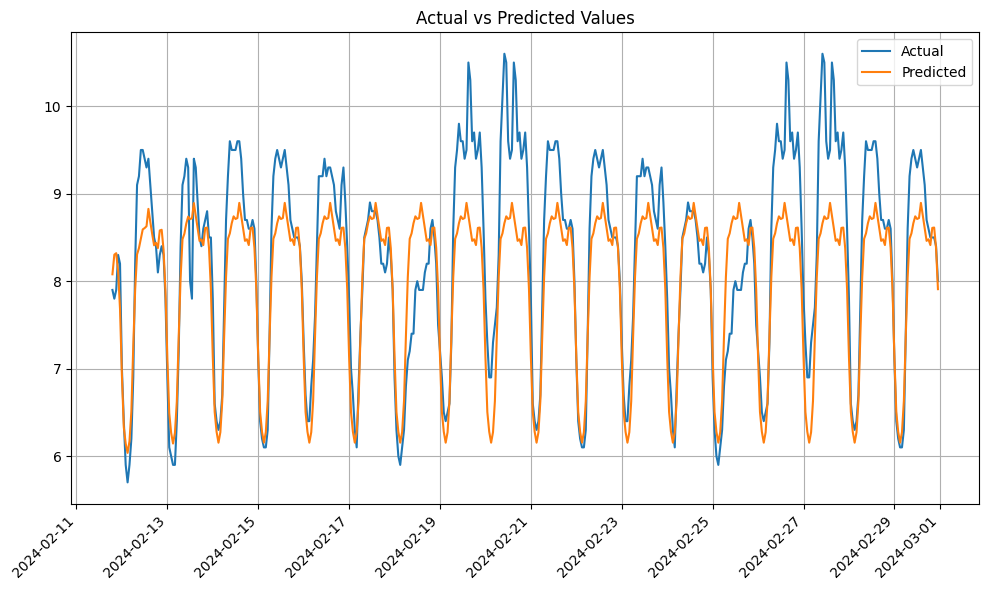

In [ ]:
# prompt: a code that uses all forms of performance meetrics to test the accuracy of the arima model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate performance metrics
mse = mean_squared_error(test_data['Load_Power(kW)'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['Load_Power(kW)'], predictions)
r2 = r2_score(test_data['Load_Power(kW)'], predictions)

# Print the results
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2):', r2)

# Optional: Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_data['Load_Power(kW)'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid()
plt.show()


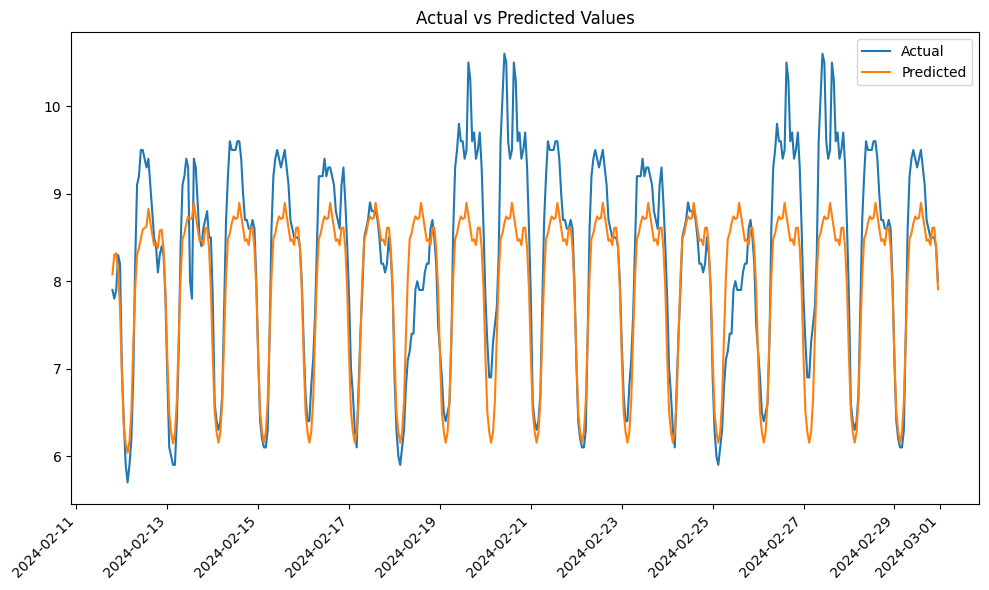

In [ ]:
# prompt: give me a code to organize the xlabel of the plot above to be more organised

plt.figure(figsize=(10, 6))
plt.plot(test_data['Load_Power(kW)'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Assuming 'test_data' and 'rolling_predictions' are Pandas Series
mape = mean_absolute_percentage_error(test_data, predictions)
print("MAPE:", mape)

MAPE: 15.194450811788245


In [ ]:
predictions.head()

,predicted_mean
Date,
2024-02-11 19:00:00,8.078855
2024-02-11 20:00:00,8.303360
2024-02-11 21:00:00,8.320063
2024-02-11 22:00:00,8.111913
2024-02-11 23:00:00,7.683516


Text(0, 0.5, 'Error')

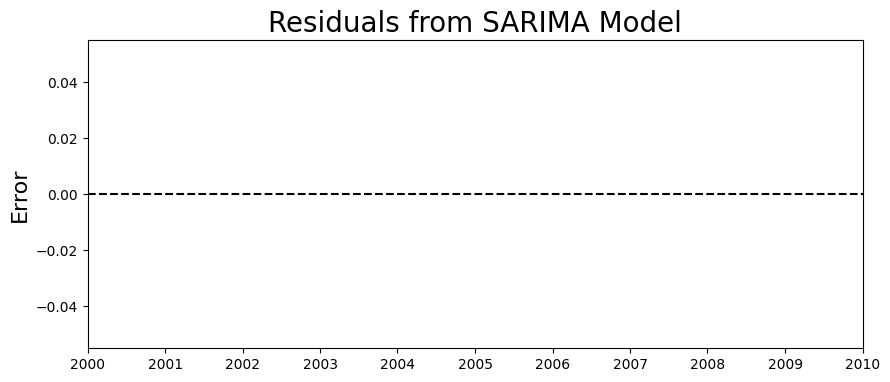

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Power')

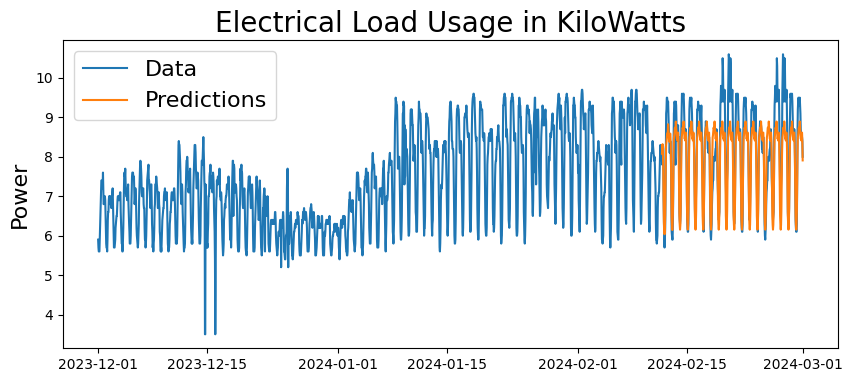

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(bts_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Electrical Load Usage in KiloWatts', fontsize=20)
plt.ylabel('Power', fontsize=16)
#for year in range(start_date.year,end_date.year):
    #plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: nan


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


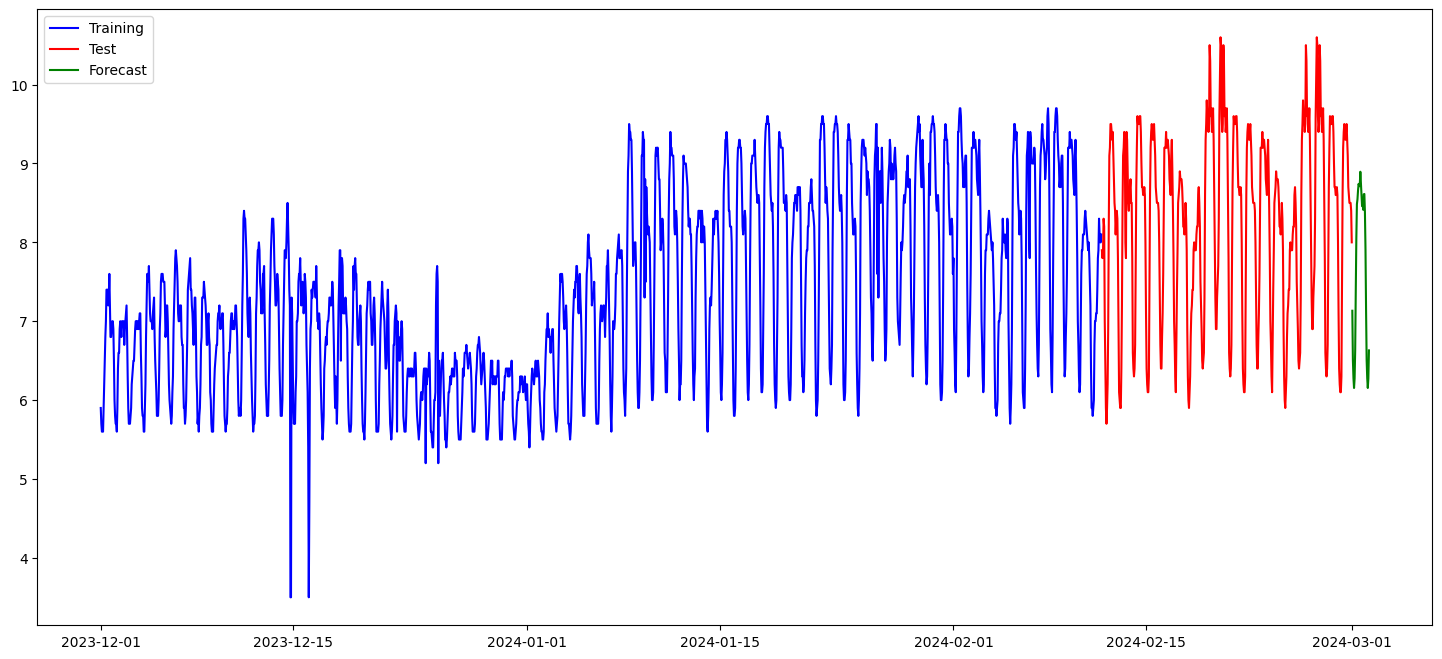

In [ ]:
# prompt: forecast the next 30 hrs data after the test and train data

# Forecast for the next 30 hrs
forecast = model_fit.predict(start = len(bts_data),
                          end = (len(bts_data)-1) + 30,
                          typ = 'levels').rename('Forecast')

# Plot the forecast
plt.figure(figsize=(18,8))
plt.plot(train_data['Load_Power(kW)'], label='Training', color='blue')
plt.plot(test_data['Load_Power(kW)'], label='Test', color='red')
plt.plot(forecast, label='Forecast', color='green')
plt.legend(loc='best')
plt.show()


In [ ]:
# prompt: print the forecast values

print(forecast)


2024-03-01 00:00:00    7.132803
2024-03-01 01:00:00    6.505016
2024-03-01 02:00:00    6.278901
2024-03-01 03:00:00    6.153698
2024-03-01 04:00:00    6.273774
2024-03-01 05:00:00    6.630090
2024-03-01 06:00:00    7.369918
2024-03-01 07:00:00    8.047099
2024-03-01 08:00:00    8.484323
2024-03-01 09:00:00    8.546631
2024-03-01 10:00:00    8.662148
2024-03-01 11:00:00    8.741298
2024-03-01 12:00:00    8.711042
2024-03-01 13:00:00    8.722049
2024-03-01 14:00:00    8.895070
2024-03-01 15:00:00    8.750007
2024-03-01 16:00:00    8.604442
2024-03-01 17:00:00    8.461211
2024-03-01 18:00:00    8.478799
2024-03-01 19:00:00    8.413048
2024-03-01 20:00:00    8.609245
2024-03-01 21:00:00    8.613205
2024-03-01 22:00:00    8.379987
2024-03-01 23:00:00    7.908887
2024-03-02 00:00:00    7.132803
2024-03-02 01:00:00    6.505016
2024-03-02 02:00:00    6.278901
2024-03-02 03:00:00    6.153698
2024-03-02 04:00:00    6.273774
2024-03-02 05:00:00    6.630090
Freq: H, Name: Forecast, dtype: float64
